<a href="https://colab.research.google.com/github/muymay/lectures/blob/main/MLP_%26_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. import libraries

# DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms, ToTensor
from torch.utils.data import DataLoader

# saving data
import pandas as pd

# timer
import time

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [ ]:
# use GPU, MAC specs is 24 GB of memory
device = "mps" if torch.backends.mps.is_available() else "cpu"


In [ ]:
# composes several transforms together, prepares image to be used as an input for neural network.
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
# import that data
# data loaders make it easy to efficiently feed data in batches, randomnly shuffle every epoch, and parallel loading for sped up training processes
batch_size = 16
train_data = CIFAR10(root=".", download = True, train = True, transform = ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

valid_data = CIFAR10(root=".", download = True, train = False, transform = ToTensor())
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False, num_workers = 2)

classes = ('beaver', 'dolphin', 'otter', 'seal', 'whale',
           'aquarium fish', 'flatfish', 'ray', 'shark', 'trout')


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


In [ ]:
# verify data
print(train_data)
print(valid_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()


## Define, train and evaluate MLP

Building a MLP class with two hidden layers, that is designed for classification by flattening the input of the image. Dropout in nn is then used as a regularization technique to prevent overfitting during the training of the DL model. It is applied on the outputs of the hidden layer, 10 neurons are are required, since we have 10 classes that needs to be distinguished. It applies a ReLU activation as a non0linear activation function.

In [ ]:
# initiate MLP in PyTorch with two hidden layers.
class MLP(torch.nn.Module):
  def __init__(self):
    # 1. input layer - transform flattened image data into hidden layer size 512
    # 2. second hidden layer - transform output of the first hidden layer to a size of 256
    # 3. dropout to prevent overfitting
    # 4. output - that maps second hidden layer to 10 classes of the images
    super(MLP, self).__init__() #
    # 1. take image "Each file contains 10000 such 3073-byte "rows" of images" source https://www.cs.toronto.edu/~kriz/cifar.html
    # Linear the images for classification
    self.d1 = nn.Linear(3 * 32 * 32, 512)
    # 2. output vector size of 512 hidden layer -> a vector size of 256
    self.d2 = nn.Linear(512, 256)
    # 3.
    self.dropout = nn.Dropout(p = 0.2)
    # 4. map the 10 classes from the 256 second hidden layer
    self.d3 = nn.Linear(256, 10)

  def forward(self, x):
    # 3D shape to a 1D vector
    x = x.flatten(start_dim = 1)
    x = self.d1(x) # pass flattened data to first linear layer
    x = F.relu(x) # non-linear activation
    x = self.d2(x)
    x = F.relu(x)
    x = self.dropout(x) # prevent overfitting
    node = self.d3(x)
    # apply softmax to conver the node into probabilities
    # essential to understand the model's prediction
    output = F.softmax(node, dim = 1)
    return output


Verify if the MLP model is correctly configured

In [ ]:
sanity_check = MLP()
image, labels = next(iter(train_loader))
# check if the data being loaded has the correct dimensions
print("batch size: ", image.shape)
out = sanity_check(image)
print(out.shape)

batch size:  torch.Size([16, 3, 32, 32])
torch.Size([16, 10])


##Define Parameters

This will consist the learning rate with optimized weight, epochs number of traning steps, cross compute the loss of the model with the use of torch.nn.CrossEntropyLoss. Then the optimize uses SGD to optimize its weights.


In [ ]:
def accuracy(output, target, batch_size):
  # find the maximum value for each of the 10 classes row
  pred = torch.max(output,1)[1].view(target.size())
  correct = (pred.data == target.data).sum() # compare the target and prediction
  accuracy = 100 * correct / batch_size
  return accuracy.item()

In [ ]:
learning_rate = 0.01
train_epochs = 16
model = MLP()
# setting the model to the actual GPU/device used for training
model = model.to(device)
cross = nn.CrossEntropyLoss()
optimize = torch.optim.SGD(model.parameters(), lr = learning_rate)

## Training

In [ ]:
train_accuracy_list = []
test_accuracy_list = []
train_loss_list = []
test_loss_list = []

# recording for pandas
records = []
print("Training... ")
for epoch in range(train_epochs):
  epoch_start_time = time.time() # start the timer for epoch
  train_run_loss = 0.0
  train_accuracy = 0.0
  test_run_loss = 0.0
  test_accuracy = 0.0

  model.train() # set the model in "training mode"
  for i, (image, labels) in enumerate(train_loader):
    image, labels = image.to(device), labels.to(device)
    # forward pass
    pred = model(image)
    loss = cross(pred, labels)
    # backward pass and sgd optimization
    optimize.zero_grad() # ensures the gradients are cleared before the new ones that are computed
    loss.backward()
    # update model parameter
    optimize.step()

    train_run_loss += loss.detach().item()
    train_accuracy += accuracy(pred, labels, batch_size)

  # calculate average loss and accuracy for the training epoch
  accuracy_train = train_accuracy / (i + 1)
  loss_train = train_run_loss / (i + 1)
  train_accuracy_list.append(accuracy_train)
  train_loss_list.append(loss_train)

  # validate the step
  model.eval() # set model to evaluation mode
  with torch.no_grad(): # disable gradient calc to optimize memory
    for i, (image, labels) in enumerate(valid_loader):
      image, labels = image.to(device), labels.to(device)
      # forward pass
      pred = model(image)
      loss = cross(pred, labels)
      # update
      test_run_loss += loss.item()
      test_accuracy += accuracy(pred, labels, batch_size)

    accuracy_test = test_accuracy / (i + 1)
    loss_test = test_run_loss / (i + 1)
    test_accuracy_list.append(accuracy_test)
    test_loss_list.append(loss_test)

    # calculate epoch results and time
    epoch_end_time = time.time()
    epoch_test = epoch_end_time - epoch_start_time

    # put data into a dictionary
    record = {
        'epoch': epoch + 1,
        'train_loss': loss_train,
        'train_accuracy': accuracy_train,
        'val_loss': loss_test,
        'val_accuracy': accuracy_test,
        'time_dur': epoch_test
    }
    records.append(record)

    print(f'Epoch: {record["epoch"]} | Train Loss: {record["train_loss"]:.4f} | Train Acc: {record["train_accuracy"]:.2f}% | Val. Loss: {record["val_loss"]:.4f} | Val. Acc: {record["val_accuracy"]:.2f}% | Time: {record["time_dur"]}')

print('\nTraining Complete')

Training... 
Epoch: 1 | Train Loss: 2.1737 | Train Acc: 28.21% | Val. Loss: 2.1594 | Val. Acc: 29.59% | Time: 39.85073375701904
Epoch: 2 | Train Loss: 2.1554 | Train Acc: 29.95% | Val. Loss: 2.1437 | Val. Acc: 31.55% | Time: 39.53809189796448
Epoch: 3 | Train Loss: 2.1370 | Train Acc: 31.98% | Val. Loss: 2.1186 | Val. Acc: 34.53% | Time: 39.58422899246216
Epoch: 4 | Train Loss: 2.1185 | Train Acc: 34.11% | Val. Loss: 2.1055 | Val. Acc: 35.57% | Time: 39.90397262573242
Epoch: 5 | Train Loss: 2.1061 | Train Acc: 35.31% | Val. Loss: 2.1011 | Val. Acc: 35.90% | Time: 40.79927730560303
Epoch: 6 | Train Loss: 2.0957 | Train Acc: 36.37% | Val. Loss: 2.0876 | Val. Acc: 37.37% | Time: 40.19977617263794
Epoch: 7 | Train Loss: 2.0882 | Train Acc: 37.07% | Val. Loss: 2.0806 | Val. Acc: 37.94% | Time: 40.13397288322449
Epoch: 8 | Train Loss: 2.0805 | Train Acc: 37.86% | Val. Loss: 2.0742 | Val. Acc: 38.47% | Time: 39.323590993881226
Epoch: 9 | Train Loss: 2.0730 | Train Acc: 38.74% | Val. Loss: 2.0

## Plot the data


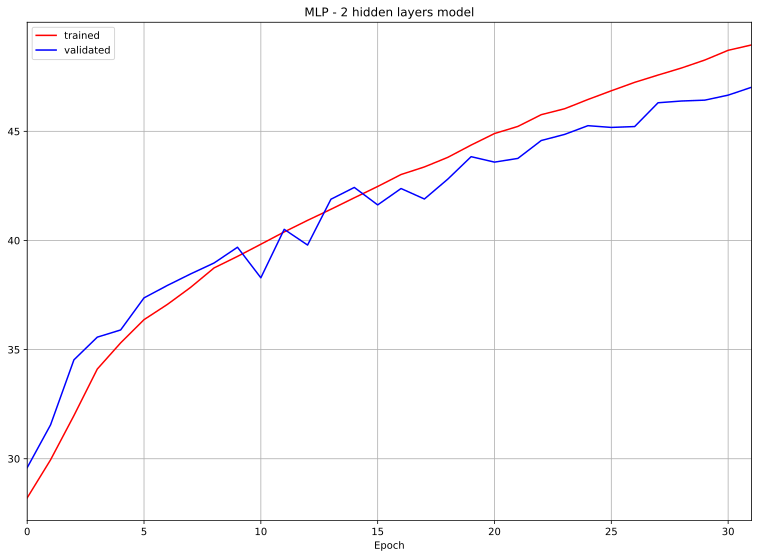

In [ ]:
plt.figure(figsize = (13,9))
plt.plot(range(train_epochs), train_accuracy_list, "r", label = "trained")
plt.plot(range(train_epochs), test_accuracy_list, "b", label = "validated")
plt.xlabel("Epoch")
plt.xlim(0, train_epochs - 1)
plt.title("MLP - 2 hidden layers model")
plt.grid(True)
plt.legend()
plt.show()

## Save the results into a CSV file


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_records.html

In [ ]:
df = pd.DataFrame.from_records(records).to_csv("mlp_records")

## Extra Experiment


How do different learning rates affect model performance (i.e., loss or accuracy)?


## Define CNN


https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html for Conv2d

The goal is a simple 2D Convolutional Neural Network with atleast two hidden layers, that is designed for the 32*32 pixel images provided in the CIFAR 10 dataset

For the first convolutional the out channel is 32 since its going to detect its basic, low-level features, the second convolutional layer, more diverse features and try to recognize more advance patterns, like its texture and details.

Each of the layers is applied a reLU activation


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.c1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
    self.p1 = nn.MaxPool2d(2, 2) # reduce dimension by half
    self.c2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.p2 = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(p = 0.2) # prevent overfitting
    self.f1 = nn.Linear(2048, 256)
    self.dropout = nn.Dropout(p = 0.2)
    self.f2 = nn.Linear(256, 128) # output layer of 10 classes
    self.dropout = nn.Dropout(p = 0.2)
    self.f3 = nn.Linear(128, 10)

  def forward(self, x):
    # first c1 with relu and max pooling, iterate for c2
    x = F.relu(self.c1(x))
    x = self.p1(x)
    x = F.relu(self.c2(x))
    x = self.p2(x)
    # flatten the maps for dense layers
    x = torch.flatten(x, 1)
    x = self.f1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.f2(x)
    x = F.relu(x)
    x = self.dropout(x)
    # dense layer 2 for classification
    node = self.f3(x)
    return node

model_CNN = CNN()
model_CNN
model_CNN.to(device)


CNN(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (f1): Linear(in_features=2048, out_features=256, bias=True)
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

## Define Parameters


In [ ]:
cnn_cross = nn.CrossEntropyLoss()
# momentum is used here to smoothen optimization path, reduce oscillations and reaching a faster result
cnn_optimize = torch.optim.SGD(model_CNN.parameters(), lr = 0.01, momentum = 0.5)

## Training


In [ ]:
cnn_train_accuracy_list = []
cnn_test_accuracy_list = []
cnn_train_loss_list = []
cnn_test_loss_list = []

# recording for pandas
cnn_records = []
for epoch in range(train_epochs):
  cnn_epoch_start_time = time.time()
  cnn_train_loss = 0.0
  cnn_train_accuracy = 0.0
  cnn_test_loss = 0.0
  cnn_test_accuracy = 0.0

  model_CNN.train() # train mode
  for i, (image, labels) in enumerate(train_loader):
    # model_CNN.train() # train mode
    image = image.to(device)
    labels = labels.to(device)
    pred = model_CNN(image)
    cnn_loss = cnn_cross(pred, labels)
    # backward pass and sgd optimization
    cnn_optimize.zero_grad() # ensures the gradients are cleared before the new ones that are computed
    cnn_loss.backward()
    # update model parameter
    cnn_optimize.step()

    cnn_train_loss += cnn_loss.detach().item()
    cnn_train_accuracy += accuracy(pred, labels, batch_size)

  cnn_accuracy_train = cnn_train_accuracy / i
  cnn_loss_train = cnn_train_loss / i
  cnn_train_accuracy_list.append(cnn_accuracy_train)
  cnn_train_loss_list.append(cnn_loss_train)

  model_CNN.eval()
  with torch.no_grad():
    for i, (image, labels) in enumerate(valid_loader):
      model_CNN.eval()
      image = image.to(device)
      labels = labels.to(device)
      pred = model_CNN(image)
      cnn_loss = cnn_cross(pred, labels)

      cnn_test_loss += cnn_loss.item()
      cnn_test_accuracy += accuracy(pred, labels, batch_size)

  cnn_accuracy_test = cnn_test_accuracy / i
  cnn_loss_test = cnn_test_loss / i
  cnn_test_accuracy_list.append(cnn_accuracy_test)
  cnn_test_loss_list.append(cnn_loss_test)

  # calculate epoch results and time
  cnn_epoch_end_time = time.time()
  cnn_epoch_test = cnn_epoch_end_time - cnn_epoch_start_time

  # put data into a dictionary
  record = {
      'epoch': epoch + 1,
      'cnn_train_loss': cnn_loss_train,
      'cnn_train_accuracy': cnn_accuracy_train,
      'cnn_val_loss': cnn_loss_test,
      'cnn_val_accuracy': cnn_accuracy_test,
      'cnn_time_dur': cnn_epoch_test
    }
  cnn_records.append(record)

  print(f'Epoch: {record["epoch"]} | Train Loss: {record["cnn_train_loss"]:.4f} | Train Acc: {record["cnn_train_accuracy"]:.2f}% | Val. Loss: {record["cnn_val_loss"]:.4f} | Val. Acc: {record["cnn_val_accuracy"]:.2f}% | Time: {record["cnn_time_dur"]}')

print('\nTraining Complete')



Epoch: 1 | Train Loss: 1.9517 | Train Acc: 27.99% | Val. Loss: 1.6076 | Val. Acc: 42.47% | Time: 79.02823138237
Epoch: 2 | Train Loss: 1.4976 | Train Acc: 45.77% | Val. Loss: 1.3970 | Val. Acc: 49.34% | Time: 78.44460844993591
Epoch: 3 | Train Loss: 1.3095 | Train Acc: 53.00% | Val. Loss: 1.2376 | Val. Acc: 55.99% | Time: 77.17020869255066
Epoch: 4 | Train Loss: 1.1650 | Train Acc: 58.78% | Val. Loss: 1.1165 | Val. Acc: 61.11% | Time: 76.91660141944885
Epoch: 5 | Train Loss: 1.0545 | Train Acc: 62.48% | Val. Loss: 1.0810 | Val. Acc: 62.12% | Time: 78.56809425354004
Epoch: 6 | Train Loss: 0.9609 | Train Acc: 66.02% | Val. Loss: 0.9727 | Val. Acc: 65.51% | Time: 80.23876810073853
Epoch: 7 | Train Loss: 0.8849 | Train Acc: 68.55% | Val. Loss: 0.9536 | Val. Acc: 67.03% | Time: 75.50634264945984
Epoch: 8 | Train Loss: 0.8095 | Train Acc: 71.51% | Val. Loss: 0.9039 | Val. Acc: 68.98% | Time: 77.48860502243042
Epoch: 9 | Train Loss: 0.7437 | Train Acc: 73.60% | Val. Loss: 0.8722 | Val. Acc: 6

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## plot the data


In [ ]:
plt.figure(figsize = (13,9))
plt.plot(range(train_epochs), cnn_train_accuracy_list, "r", label = "trained")
plt.plot(range(train_epochs), cnn_test_accuracy_list, "b", label = "validated")
plt.xlabel("Epoch")
plt.xlim(0, train_epochs - 1)
plt.title("CNN - 2 hidden layers model")
plt.grid(True)
plt.legend()
plt.show()

## Save the result in CSV file


In [ ]:
df = pd.DataFrame.from_records(cnn_records).to_csv("cnn_records")